# DOWNLOAD & EXTRACT DATASET

In [11]:
!gdown 1BVpkgbxN21kTcIGsv4T7zIyT2egxIufK
import zipfile
os.makedirs('/kaggle/working/ssl_dataset')
with zipfile.ZipFile('/kaggle/working/ssl_dataset_resized.zip') as f:
    f.extractall('/kaggle/working/ssl_dataset')
import os
os.remove("/kaggle/working/ssl_dataset_resized.zip")

Downloading...
From (original): https://drive.google.com/uc?id=1BVpkgbxN21kTcIGsv4T7zIyT2egxIufK
From (redirected): https://drive.google.com/uc?id=1BVpkgbxN21kTcIGsv4T7zIyT2egxIufK&confirm=t&uuid=0df4262c-b44f-400d-bea1-56065d35bc3b
To: /kaggle/working/ssl_dataset_resized.zip
100%|██████████████████████████████████████| 2.55G/2.55G [00:44<00:00, 57.2MB/s]


# INSTALLATIONS & IMPORTS

In [2]:
import torch
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score

import os
import random
from PIL import Image, UnidentifiedImageError

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

from torch.amp import autocast, GradScaler

# CONFIGURATION

In [40]:
class config:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    image_size = 224
    patch_size = 16
    B_simclr = 128
    B_mae = 64
    mask_ratio = 0.75
    epochs_pretrain = 100
    epochs_linear_eval = 5
    dataset_path = '/kaggle/working/ssl_dataset'
    num_classes = 100
    simclr_lr = 0.001
    mae_lr = 0.0001
    embed_dim = 512

# TRAIN DATASET LOADER

In [13]:
class simclr_dataset(Dataset):
    def __init__(self, path, transform):
        super(train_folder_dataset, self).__init__()
        self.image_filenames = os.listdir(path)
        self.folder_path = path
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        while True:
            try:
                image = Image.open(os.path.join(self.folder_path, self.image_filenames[index])).convert('RGB')
                return self.transform(image), self.transform(image)
            except (UnidentifiedImageError, OSError):
                index = (index + 1) % len(self.image_filenames)

class mae_dataset(Dataset):
    def __init__(self, path, transform):
        super(mae_dataset, self).__init__()
        self.image_filenames = os.listdir(path)
        self.folder_path = path
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        while True:
            try:
                image = Image.open(os.path.join(self.folder_path, self.image_filenames[index])).convert('RGB')
                return self.transform(image)
            except (UnidentifiedImageError, OSError):
                index = (index + 1) % len(self.image_filenames)
        
def get_transform(sim=True):
    if sim:
        return T.Compose([
            T.RandomResizedCrop(config.image_size),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.4, 0.4, 0.4, 0.1),
            T.RandomGrayscale(p=0.2),
            T.GaussianBlur(25),
            T.ToTensor(),
            T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])
    else:
        return T.Compose([
            T.Resize((config.image_size, config.image_size)),
            T.ToTensor(),
            T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])

def train_dataloader(sim=True):
    batch_size = config.B_simclr if sim else config.B_mae
    
    train_folder = os.path.join(config.dataset_path, "train_unlabeled")

    train_data = simclr_dataset(train_folder, get_transform(True))
    if not sim:
        train_data = mae_dataset(train_folder, get_transform(False))

    train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2)

    return train_loader

# LINEAR EVALUATION DATASET LOADER

In [14]:
def linear_dataloader():
    batch_size = 128
    train_folder = os.path.join(config.dataset_path, "train_labeled")

    train_data = ImageFolder(train_folder, transform = get_transform(sim=False))

    return DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2)

# SimCLR MODEL

In [5]:
class SimCLR(nn.Module):
    def __init__(self, encoder, embed_dim = 512, projection_dim = 128):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.projection_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU('tanh'),
            nn.Linear(embed_dim, projection_dim)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.projection_head(x)
        return x

# CONTRASTIVE LOSS

In [6]:
def sim_loss(z_i, z_j, temperature = 0.5):
    z_i = F.normalize(z_i, dim=1)
    z_j = F.normalize(z_j, dim=1)

    r = torch.stack([z_i, z_j], dim=1).reshape(-1, z_i.size(1))
    sim = torch.matmul(r, r.T)

    mask = torch.eye(sim.size(0), dtype=torch.bool).to(z_i.device)
    sim.masked_fill_(mask, float('-inf'))

    logits = F.log_softmax(sim, dim=1)

    pos = torch.arange(z_i.size(0)).to(z_i.device)
    pos_i = pos ^ 1

    return -logits[pos, pos_i].mean()

# SimCLR TRAINING LOOP

In [8]:
def train_simclr(model, train_loader, optimizer):
    optimizer.zero_grad()
    scaler = GradScaler('cuda')
    model.train()
    losses = []
    for epoch in range(config.epochs_pretrain):
        batch = 0
        for z1, z2 in tqdm(train_loader, leave=False):
            batch += 1
            with autocast('cuda'):
                z1, z2 = model(z1.to(config.device)), model(z2.to(config.device))
                loss = sim_loss(z1, z2)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            losses.append(loss.item())

            torch.save({
                'epoch': epoch,
                'batch': batch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'losses': losses
            }, '/kaggle/working/simclr_checkpoint.pth')
            
        print(f"Epoch: {epoch}/{config.epochs_pretrain}, Loss: {(sum(losses[-len(train_loader):])/len(train_loader)):.4f}")

    return losses

# SimCLR PRETRAINING RUNNER

In [9]:
train_loader = train_dataloader(sim=True)

resnet = models.resnet18(pretrained = False)
resnet.fc = nn.Identity()

model = SimCLR(encoder = resnet).to(config.device)
model = model.to(config.device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.simclr_lr)

losses_simclr = train_simclr(model, train_loader, optimizer)

torch.save(model.encoder.state_dict(), '/kaggle/working/simclr_encoder.pth')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/753 [00:00<?, ?it/s]

Epoch: 0/100, Loss: 5.0685


  0%|          | 0/753 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 15))
axis = torch.arange(len(losses_simclr))/len(train_loader)
plt.plot(losses_simclr, axis)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("SimCLR Pretraining Loss (Batch-wise)")
plt.grid(True)
plt.show()

# SimCLR LINEAR EVALUATION

## SimCLR Checkpoint Loading

In [54]:
!gdown 
checkpoint = torch.load('/kaggle/working/simclr_encoder.pth', map_location=config.device, weights_only=False)
resnet = models.resnet18(pretrained = False)
resnet.fc = nn.Identity()
resnet.load_state_dict(checkpoint['model'])

Downloading...
From (original): https://drive.google.com/uc?id=17YvDD_m9C-M1ff5F1KV5QX4AbztE-PCJ
From (redirected): https://drive.google.com/uc?id=17YvDD_m9C-M1ff5F1KV5QX4AbztE-PCJ&confirm=t&uuid=ff2eb240-0ba2-424b-ae7b-f4541dddbc2b
To: /kaggle/working/simclr_checkpoint.pth
100%|████████████████████████████████████████| 138M/138M [00:03<00:00, 41.0MB/s]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## SimCLR Linear Evaluation Model

In [ ]:
def sim_linear_model(encoder):
    return nn.Sequential(
        encoder,
        nn.Linear(config.embed_dim, 100)
    )

## SimCLR Linear Evaluation Training Loop

In [ ]:
def sim_linear_training(model, train_loader, optimizer):
    losses=[]
    for epoch in range(config.epochs_linear_eval):
        total_loss = 0
        for batch, labels in tqdm(train_loader, leave=False):
            batch, labels = batch.to(config.device), labels.to(config.device)
            pred = model(batch)
            loss = nn.CrossEntropyLoss()(pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss/len(train_loader))
        print(f"Epoch: {epoch}/{config.epochs_linear_eval}, Loss: {total_loss/len(train_loader)}")
    return losses

## SimCLR Linear Evaluation Runner Code

In [ ]:
linear_loader = linear_dataloader()

resnet.eval()
for param in resnet.parameters():
    param.requires_grad = False

sim_linear = sim_linear_model(resnet)

sim_linear_optimizer = torch.optim.Adam(sim_linear[-1].parameters(), lr = 0.001)

sim_linear_losses = sim_linear_training(sim_linear, linear_loader, sim_linear_optimizer)

plt.figure(figsize=(10, 5))
plt.plot(sim_linear_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SimCLR Linear Evaluation Training Loss')
plt.grid(True)
plt.show

## SimCLR Linear Evaluation Saving Checkpoint

In [ ]:
torch.save(sim_linear.state_dict(), '/kaggle/working/simclr_linear.pth')

# MAE MODEL

In [15]:
class SimpleViTEncoder(nn.Module):
    def __init__(self, embed_dim=512, depth=6, heads=8, mlp_ratio=4):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=heads,
                dim_feedforward=embed_dim * mlp_ratio,
                activation="gelu",
                norm_first=True,
                batch_first=True
            )
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

class MAEDecoder(nn.Module):
    def __init__(self, embed_dim=512, output_dim=768, num_layers=2, num_heads=4, hidden_dim = 2048):     
        super().__init__()
        hidden_dim = embed_dim * 4

        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                batch_first=True,
                norm_first=True,
                activation="gelu"
            )
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)
        return self.head(x)

class MAE(nn.Module):
    def __init__(self, mask_ratio = 0.75, embed_dim = 512):
        super(MAE, self).__init__()
        self.mask_ratio = mask_ratio
        self.patch_size = config.patch_size
        self.patch_dim = (config.patch_size**2) * 3
        self.H = config.image_size
        self.W = self.H
        self.num_patches = (config.image_size//config.patch_size)**2

        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        self.linear_embed = nn.Linear(self.patch_dim, embed_dim)
        self.mask_tokens = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.dec_pos_embed = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        
        self.encoder = SimpleViTEncoder(embed_dim=embed_dim, depth=6, heads=8, mlp_ratio=4)
        self.decoder = MAEDecoder(embed_dim = embed_dim, output_dim = self.patch_dim)

    def patchify(self, x):
        B, C, H, W = x.shape
        p = config.patch_size
        patch = x.reshape(B, C, H//p, p, W//p, p).permute(0, 2, 4, 3, 5, 1)
        patch = patch.reshape(B, (H//p)*(W//p), p*p*C)
        return patch

    def unpatchify(self, x):
        B, N, D = x.shape
        H, W = self.H, self.W
        p = config.patch_size
        C = D//(p*p)
        x = x.reshape(B, H//p, W//p, p, p, C).permute(0, 5, 1, 3, 2, 4)
        x = x.reshape(B, C, H, W)
        return x

    def forward(self, x):
        patch = self.patchify(x.to(config.device))
        patches = self.linear_embed(patch)
        B, N, D = patches.shape
        patches = patches + self.pos_embed.repeat(B, 1, 1)
        keep = int(N*(1 - self.mask_ratio))

        noise = torch.rand(B, N, device = config.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        ids_keep = ids_shuffle[:, :keep]
        ids_mask = ids_shuffle[:, keep:]

        x = torch.gather(patches, 1, ids_keep.unsqueeze(-1).repeat(1, 1, D))

        e = self.encoder(x)
        mask_token = self.mask_tokens.repeat(B, N - x.size(1), 1)
        z = torch.concat([e, mask_token], dim=1)
        z = torch.gather(z, 1, ids_restore.unsqueeze(-1).repeat(1, 1, D))

        z = z + self.dec_pos_embed
        output = self.decoder(z)

        return output, patch, ids_mask

# MAE LOSS

In [ ]:
def mae_loss(output, patches, ids_mask):
    B, N, D = patches.shape
    output_masked = torch.gather(output, 1, ids_mask.unsqueeze(-1).repeat(1, 1, D))
    patches_masked = torch.gather(patches, 1, ids_mask.unsqueeze(-1).repeat(1, 1, D))

    return F.mse_loss(output_masked, patches_masked, reduction='mean')

# MAE TRAINING LOOP

In [ ]:
def mae_training(model, train_loader, optimizer):
    model.train()
    losses=[]
    for epoch in range(config.epochs_pretrain):
        for z in tqdm(train_loader, leave=False):
            a, b, c = model(z.to(config.device))
            loss = mae_loss(a, b, c)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print(f"Epoch: {epoch}/{config.epochs_pretrain}, Loss: {(sum(losses[-len(train_loader):])/len(train_loader)):.4f}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses
        }, '/kaggle/working/mae_checkpoint.pth')

    return losses

# MAE PRETRAINING RUNNER

In [ ]:
mae_train_loader = train_dataloader(sim=False)

mae_model = MAE().to(config.device)

mae_optimizer = torch.optim.Adam(mae_model.parameters(), lr=config.mae_lr)

losses_mae = mae_training(mae_model, mae_train_loader, mae_optimizer)

torch.save(model.encoder.state_dict(), '/kaggle/working/mae_encoder.pth')

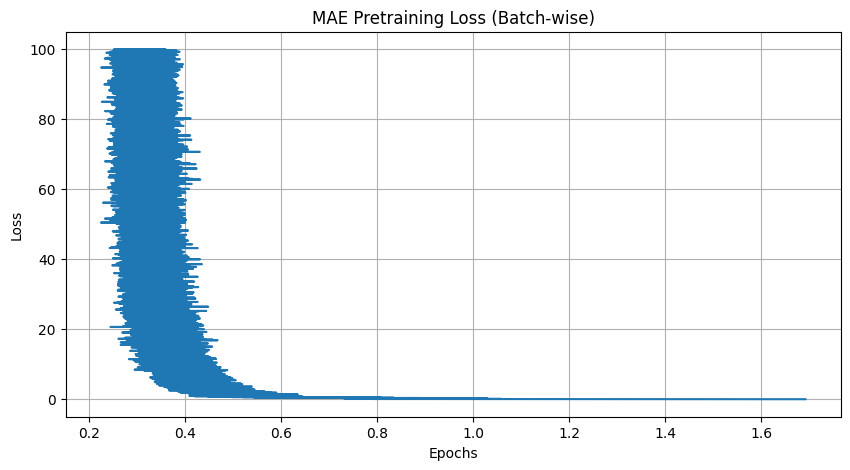

In [43]:
plt.figure(figsize=(10, 5))
axis = torch.arange(len(losses_mae))/len(train_loader)
plt.plot(losses_mae, axis)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MAE Pretraining Loss (Batch-wise)")
plt.grid(True)
plt.show()

# MAE VISUALIZATION

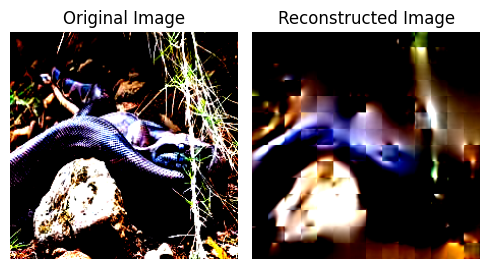

In [22]:
val_classes = os.listdir(os.path.join(config.dataset_path, 'val'))
random_class = random.choice(range(len(val_classes)))
images = os.listdir(os.path.join(config.dataset_path, 'val', val_classes[random_class]))
random_image = random.choice(range(len(images)))
image = Image.open(os.path.join(config.dataset_path, 'val', val_classes[random_class], images[random_image]))

mae_model.eval()

transform = get_transform(False)
image = transform(image)
output, _, _ = mae_model(image.unsqueeze(0))
output = mae_model.unpatchify(output)[0]

image = torch.clamp(image.cpu().permute(1, 2, 0), 0, 1).numpy()
output = torch.clamp(output.detach().cpu().permute(1, 2, 0), 0, 1).numpy()

plt.figure(figsize=(5, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output)
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# MAE LINEAR EVALUATION

## MAE Checkpoint Loading

In [18]:
!gdown 1bi7JpSUkEIJakcZYVFUDtqGYvUG2-ta8
checkpoint = torch.load('/kaggle/working/mae_checkpoint.pth', map_location=config.device, weights_only=False)
mae_model = MAE().to(config.device)
mae_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## MAE Linear Evaluation Model

In [33]:
class encoder(nn.Module):
    def __init__(self, mae_model):
        super().__init__()
        self.encoder = mae_model.encoder
        self.linear_embed = mae_model.linear_embed
        self.pos_embed = mae_model.pos_embed
        self.patchify = mae_model.patchify

    def forward(self, x):
        x = self.patchify(x)
        x = self.linear_embed(x)
        x = x + self.pos_embed
        x = self.encoder(x)
        return x.mean(dim=1)

def mae_linear(encoder):
    return nn.Sequential(
        encoder,
        nn.Linear(config.embed_dim, 100)
    ).to(config.device)

## MAE Linear Evaluation Model Training Loop

In [45]:
def mae_linear_training(model, train_loader, optimizer):
    losses=[]
    for epoch in range(4, config.epochs_linear_eval):
        total_loss = 0
        for batch, labels in tqdm(train_loader, leave=False):
            batch, labels = batch.to(config.device), labels.to(config.device)
            pred = model(batch)
            loss = nn.CrossEntropyLoss()(pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            losses.append(loss.item())
        #losses.append(total_loss/len(train_loader))
        print(f"Epoch: {epoch}/{config.epochs_linear_eval}, Loss: {total_loss/len(train_loader)}")
    return losses

## MAE Linear Evalutation Runner Code

  0%|          | 0/1016 [00:00<?, ?it/s]

Epoch: 4/5, Loss: 2.986583363118134


<function matplotlib.pyplot.show(close=None, block=None)>

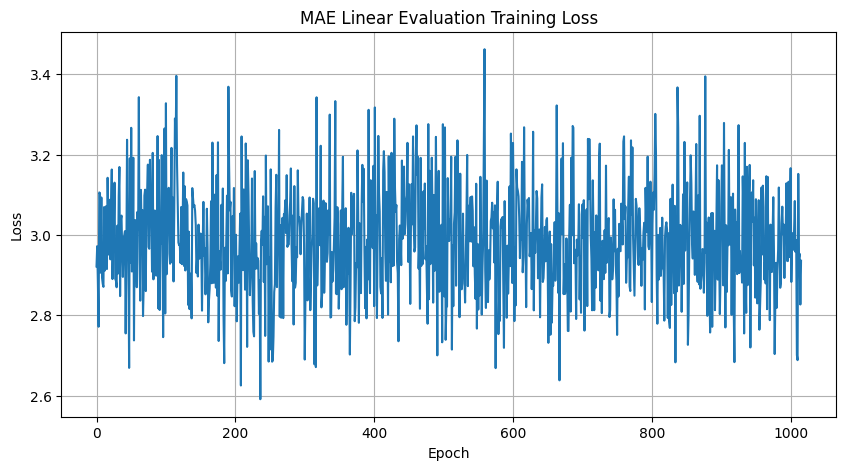

In [46]:
linear_loader = linear_dataloader()

mae_encoder = encoder(mae_model)
mae_encoder.eval()
for param in mae_encoder.parameters():
    param.requires_grad = False

mae_linear_model = mae_linear(mae_encoder)

mae_linear_optimizer = torch.optim.Adam(mae_linear_model[-1].parameters(), lr = 0.001)

mae_linear_losses = mae_linear_training(mae_linear_model, linear_loader, mae_linear_optimizer)

plt.figure(figsize=(10, 5))
plt.plot(mae_linear_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MAE Linear Evaluation Training Loss')
plt.grid(True)
plt.show

## MAE Linear Evaluation Saving Checkpoint

In [50]:
torch.save(mae_linear_model.state_dict(), "/kaggle/working/mae_linear.pth")

# FINAL EVALUATION

## Validation Dataloader

In [52]:
def val_dataloader():
    batch_size = 128
    val_folder = os.path.join(config.dataset_path, "val")

    val_data = ImageFolder(val_folder, transform = get_transform(sim=False))

    return DataLoader(val_data, batch_size = batch_size, shuffle = False, num_workers = 2)

val_loader = val_dataloader()

## SimCLR

In [ ]:
!gdown
model = sim_linear_model(models.resnet18(pretrained = False))
model.load_state_dict(torch.load("/kaggle/working/sim_linear.pth"))
model.eval()
model.to(config.device)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(config.device)
        labels = labels.to(config.device)

        logits = model(images)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Final SimCLR Linear Evaluation Accuracy: {acc*100:.2f}%")
print(f"Final SimCLR Linear Evaluation F1 Score:  {f1:.4f}")

## MAE

In [53]:
!gdown 1YuWhf246pUSXlFFyfjLNL6bq5-Mq97FZ
model = mae_linear(encoder(MAE()))
model.load_state_dict(torch.load('/kaggle/working/mae_linear.pth'))
model.eval()
model.to(config.device)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(config.device)
        labels = labels.to(config.device)

        logits = model(images)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Final MAE Linear Evaluation Accuracy: {acc*100:.2f}%")
print(f"Final MAE Linear Evaluation F1 Score:  {f1:.4f}")

Final MAE Linear Evaluation Accuracy: 25.08%
Final MAE Linear Evaluation F1 Score:  0.2337
